In [20]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
from collections import Counter
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

from datetime import datetime, timedelta

import operator

import mpmath as mp
from importlib import reload

from utils import utils, net_lstm, net_lstm_w2v
from tqdm import tqdm
import random
sns.set()
from geopy.distance import distance


torch.manual_seed(1)

In [26]:
reload(utils)
# Getting a list of valid candidates given properties
pep_info = pd.read_pickle("data_inf.pkl")

pep_600 = list(pep_info[(pep_info["length"]>1000)].index)
good_peps = np.loadtxt('good_peps.txt',dtype=int)

#Draw random people
train_peps = good_peps[good_peps<=600]
train_peps = np.array(list(set(train_peps).intersection(pep_600)))

train_peps_all = good_peps
train_peps_all = np.array(list(set(train_peps_all).intersection(pep_600)))

train_peps_vali = good_peps[good_peps>600]
train_peps_vali = np.array(list(set(train_peps_vali).intersection(pep_600)))

_, dat_test_all = utils.load_train_test_set(train_peps_all,bs=10)
#_, dat_test_vali = utils.load_train_test_set([771],bs=10)

In [27]:
reload(net_lstm_w2v)
net = net_lstm_w2v.Brain()
net.bs = 1
net.seq_len=100

net.create_model()
net.model.load_state_dict(torch.load("Network/network_epoch_0.338_Feb-23-2020"))

<All keys matched successfully>

In [28]:
net_res = net.test(dat_test_all,pep_acc = True)

Test loss: 1.184 | Test accu: 0.338 | Test accu expl: 0.820 | Test expl AUC: 0.712 | 

In [29]:
km = []
#pep = 718
for pep in train_peps_all:
    km.append([])
    path_guess_target = np.transpose(np.array([net_res[1][pep]['guess'],net_res[1][pep]['target']]))
    with open(f"Data_m_loc/{pep}/stop_coords.json") as json_file:
        data_loc = np.array(json.load(json_file))
    df_labels = pd.read_pickle(f"Data/{pep}/label_dict.pkl")
    with open(f"Data_m_loc/{pep}/final_series.json") as json_file:
        data_path = np.array(json.load(json_file))
    data_path = np.array([i[-1] for i in data_path])
    true_labels = data_path[int(data_path.shape[0]*0.9):]
    guess_labels = (df_labels.loc[net_res[1][pep]['guess']]).to_numpy().ravel().astype('int')

    for coord_1, coord_2 in zip(data_loc[true_labels],data_loc[guess_labels]):
        km[-1].append(distance(coord_1,coord_2).km)


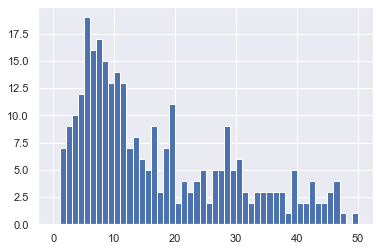

In [30]:
plt.hist([np.mean(i) for i in km],bins=50, range=[0, 50]);

In [31]:
km_ravel = [item for sublist in km for item in sublist]

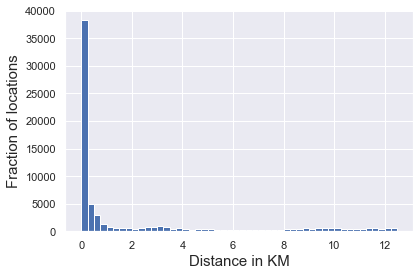

In [32]:
sns.set()
weights = np.ones_like(km_ravel)/float(len(km_ravel))

gridsize = (1,1)
fig, ax = plt.subplots(figsize=(6,4))

#plt.hist(km_ravel,bins = 50, range=[0, 12.5],weights=weights);
sns.distplot(km_ravel,bins = 50,ax=ax,kde=False,color="b",hist_kws={"alpha": 1,"range": [0,12.5]})
plt.ylabel('Fraction of locations',fontsize=15)
plt.xlabel('Distance in KM',fontsize=15)
plt.tight_layout()
plt.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\distance.eps', format='eps', dpi=300)
#plt.yscale('log')

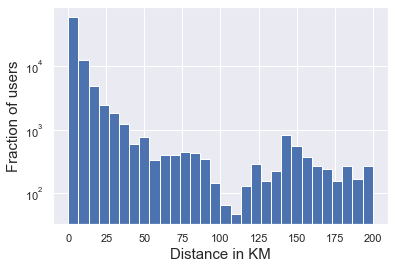

In [33]:
plt.hist(km_ravel,bins = 30,range=[0, 200]);
plt.ylabel('Fraction of users',fontsize=15)
plt.xlabel('Distance in KM',fontsize=15)
#plt.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\distance.eps', format='eps', dpi=300)
plt.yscale('log')

In [34]:
values, base = np.histogram(km_ravel,bins = 100000)
km_cum = np.cumsum(values)/sum(values)
km_cum = np.insert(km_cum,0,0.335)
#km_cum = np.insert(km_cum,0,0)

(0, 1)

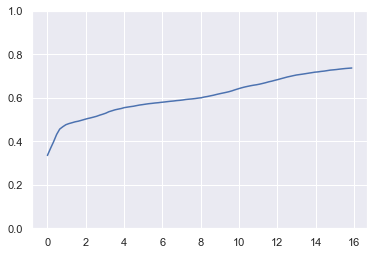

In [35]:
ii_end = 100
plt.plot(base[:ii_end],km_cum[:ii_end])
plt.ylim(0,1)

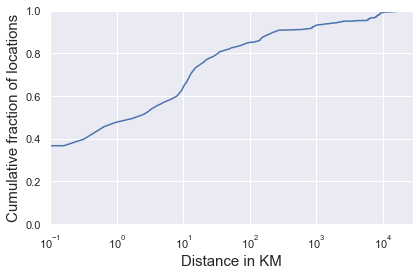

In [36]:
gridsize = (1,1)
fig, ax = plt.subplots(figsize=(6,4))

#plt.plot(base,km_cum)
sns.lineplot(base,km_cum,ax=ax)
plt.xscale('log')
plt.xlabel("Distance in KM",fontsize=15)
plt.ylabel("Cumulative fraction of locations",fontsize=15)
plt.ylim(0,1)
plt.xlim(0.1)
plt.tight_layout()
plt.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\distance_cum.eps', format='eps', dpi=300)

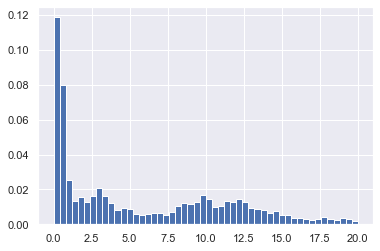

In [37]:
km_ravel = np.array(km_ravel)
km_none_zero = km_ravel[km_ravel!=0]
weights = np.ones_like(km_none_zero)/float(len(km_none_zero))
plt.hist(km_none_zero,bins = 50, range=[0, 20],weights=weights);

In [38]:
np.median(km_none_zero)

11.287461188254525

In [39]:
len(km[km==0])/len(km)

0.47534516765285995

# Distance for all travels

In [40]:
km_all = []
#pep = 718
for pep in train_peps_all:
    #path_guess_target = np.transpose(np.array([net_res[1][pep]['guess'],net_res[1][pep]['target']]))
    with open(f"Data_m_loc/{pep}/stop_coords.json") as json_file:
        data_loc = np.array(json.load(json_file))
    df_labels = pd.read_pickle(f"Data/{pep}/label_dict.pkl")
    with open(f"Data_m_loc/{pep}/final_series.json") as json_file:
        data_path = np.array(json.load(json_file))
    data_path = np.array([i[-1] for i in data_path])
    true_labels = data_path
    #guess_labels = (df_labels.loc[net_res[1][pep]['guess']]).to_numpy().ravel().astype('int')

    for coord_1, coord_2 in zip(data_loc[true_labels[:-1]],data_loc[true_labels[1:]]):
        km_all.append(distance(coord_1,coord_2).km)

In [41]:
values, base = np.histogram(km_all,bins = 100000)
km_all_cum = np.cumsum(values)/sum(values)
#km_cum = np.insert(km_cum,0,0)

In [42]:
km

[[9093.18611176844,
  9089.373541074725,
  9093.340867423742,
  0.0,
  0.0,
  0.0,
  9675.253477621322,
  0.039781611661920936,
  9093.18611176844,
  9675.08856844296,
  0.0,
  9094.293062497674,
  9089.379958547202,
  9.200412022495962,
  0.0,
  9.361576263869129,
  9675.692436915255,
  0.0,
  10.846158695168494,
  0.0,
  0.039781611661920936,
  9675.81115437074,
  0.0,
  9089.379958547202,
  9094.138422217242,
  0.0,
  9.200412022495962,
  0.0,
  9676.2894550362,
  0.0,
  9093.970304054583,
  9686.31501674477,
  9102.051572065882,
  9101.541891806113,
  0.0,
  0.0,
  0.0,
  9675.81115437074,
  0.0,
  9089.379958547202,
  0.0,
  9686.254879991848,
  9686.09940421413,
  9686.04956674483,
  39.1251120016343,
  28.6628743646564,
  9100.380293630575,
  9087.97559284271,
  39.1251120016343,
  9084.245181829974,
  9084.135471712314,
  9084.245181829974,
  39.1251120016343,
  9089.100834052842,
  9088.792050296943,
  9087.53416850047,
  9088.14646053587,
  9087.53416850047,
  39.125112001634

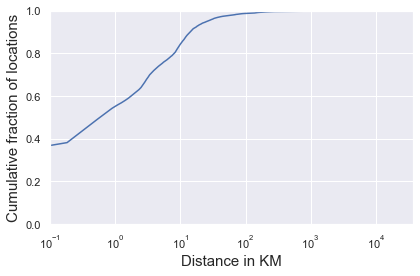

In [44]:
gridsize = (1,1)
fig, ax = plt.subplots(figsize=(6,4))

#plt.plot(base,km_cum)
sns.lineplot(base[:-1],km_all_cum,ax=ax)
plt.xscale('log')
plt.xlabel("Distance in KM",fontsize=15)
plt.ylabel("Cumulative fraction of locations",fontsize=15)
plt.ylim(0,1)
plt.xlim(0.1)
plt.tight_layout()
plt.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\distance_cum_all_locations.eps', format='eps', dpi=300)

Kig på hvis man kun kigger på dem hvor det ikke er et xploration jump